In [123]:
#!source /home/abhirup.ghosh/opt/lalsuite_padynamics_RD_parspec_e6a04843_20210714/etc/lalsuiterc 
#.local/bin/jupyter notebook --no-br

In [124]:
import os

import numpy as np
import lal
import lalsimulation as lalsim
import sys
sys.path.append("../scripts")

import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy

import matplotlib.pyplot as plt

plt.style.use("../papers/intro_paper/MATPLOTLIB_RCPARAMS.sty") 
import corner

In [125]:
# construct effective quantities from PE samples
def eff_quant(m1, m2, a1z, a2z, domega, dtau, lm):
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)
    
    return freq_GR, tau_GR, freq_modGR, tau_modGR

def eff_quant_parspec(m1, m2, a1z, a2z, dL, domega220, dtau220, domega210, dtau210, alphaNGR, pNGR):
    
    f_220 = np.zeros(len(m1))
    tau_220 = np.zeros(len(m1))
    
    for idx in range(len(m1)):
    
        i, finalMass, finalSpin = lalsim.SimIMREOBFinalMassSpin(m1[idx], m2[idx], \
                                                             np.array([0., 0., a1z[idx]]), np.array([0., 0., a2z[idx]]), \
                                                             lalsim.SEOBNRv4)
        
        z = dL[idx] * 70000.0 / 1.0e6 / lal.PC_SI / lal.C_SI;

        mtot = m1[idx] + m2[idx]
        
        finalMass_SI = finalMass * mtot * lal.MSUN_SI;
        finalSpin_rescaled = finalSpin * finalMass;

        gammaNGR = pow(alphaNGR[idx] * 1.0e3 * lal.C_SI * lal.C_SI * (1. + z)/ lal.G_SI / finalMass_SI, pNGR)

        omegaNGR = 0.3737 * (1. + gammaNGR*domega220[idx]) + 0.1258*finalSpin_rescaled * (1. + gammaNGR*domega210[idx]);
        omegaGR = 0.0717*pow(finalSpin_rescaled,2) + 0.0480*pow(finalSpin_rescaled,3) + 0.0350*pow(finalSpin_rescaled,4);

        tauNGR = 11.2407 * (1. + gammaNGR*dtau220[idx]) +  0.2522*finalSpin_rescaled * (1. + gammaNGR*dtau210[idx]);
        tauGR = 0.6649*pow(finalSpin_rescaled,2) + 0.5866*pow(finalSpin_rescaled,3) + 0.5797*pow(finalSpin_rescaled,4);
                
        omega_220 = (omegaNGR + omegaGR)/finalMass / (mtot * lal.MTSUN_SI)
        f_220[idx] = omega_220/(2.*np.pi)
        
        tau_220[idx] = finalMass * (mtot * lal.MTSUN_SI) * (tauGR + tauNGR)
        
    return f_220, tau_220


def gamma_delta(alphaNGR, z, Mf, pNGR):    
    return (alphaNGR * 1.0e3 * lal.C_SI * lal.C_SI * (1. + z)/ lal.G_SI / Mf / lal.MSUN_SI)**pNGR

# pSEOB data

In [126]:
f_pseob, tau_pseob = np.genfromtxt("../runs/O1O2/GW150914/220/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat", unpack=True)
tau_pseob *= 1000.

domega220_pseob, dtau220_pseob = np.genfromtxt("../runs/O1O2/GW150914/220/cbcBayes/qnmtest/qnmtest_frac_params_data.dat", unpack=True)

data_pseob = np.genfromtxt("../runs/O1O2/GW150914/220/cbcBayes/posterior_samples.dat", names=True, dtype=None)
mf_pseob, af_pseob, dL_pseob, z_pseob = data_pseob['mf_evol'], data_pseob['af_evol'], data_pseob['dist'], data_pseob['redshift']

# p=0:
#### We compare results for 2 ParSpec runs ({domega220} and {domega220,dtau220}) with pre-existing pSEOB results for GW150914.

In [127]:
pNGR = 0.
alphaNGR_rep = 1.

In [128]:
# ParsSpec data locations
parspec_root = "../runs/O1O2/GW150914/parspec_runs/"
parspec_p0_cases = ["p0_df0", "p0_df0_dtau0"]
parspec_p0_cases_labels = ["p0\_df0", "p0\_df0\_dtau0"]

<Figure size 864x864 with 0 Axes>

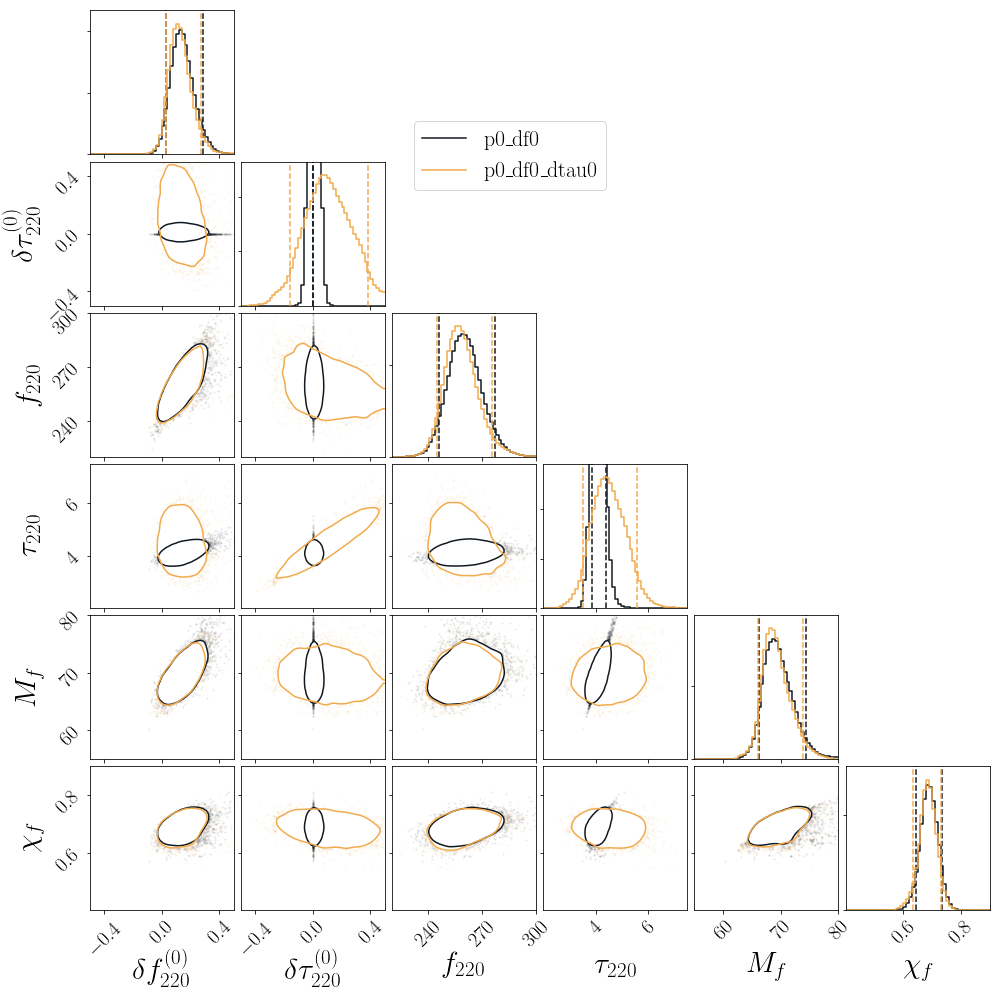

In [129]:
colors = ['#101820FF', '#F2AA4CFF']

plt.figure(figsize=(12,12))

nsamples = len(domega220_pseob)

for idx, case in enumerate(parspec_p0_cases):

    data_parspec = np.genfromtxt(parspec_root + 
                    "/" + case + "/cbcBayes/posterior_samples.dat", names=True, dtype=None)

    m1, m2, a1z, a2z, r = data_parspec["m1"], data_parspec["m2"], \
                            data_parspec["a1z"], data_parspec["a2z"], \
                            data_parspec["dist"]

    if "domega220" in data_parspec.dtype.names:
        domega220 = data_parspec["domega220"]
    else:
        domega220 = np.zeros(len(m1))
    if "dtau220" in data_parspec.dtype.names:
        dtau220 = data_parspec["dtau220"]
    else:
        dtau220 = np.zeros(len(m1))        
    if "domega210" in data_parspec.dtype.names:
        domega210 = data_parspec["domega210"]
    else:
        domega210 = np.zeros(len(m1))        
    if "dtau210" in data_parspec.dtype.names:
        dtau210 = data_parspec["dtau210"]
    else:
        dtau210 = np.zeros(len(m1))        
    if "alphaNGR" in data_parspec.dtype.names:
        alphaNGR = data_parspec["alphangr"]
    else:
        alphaNGR = np.ones(len(m1)) * alphaNGR_rep # multiply alphaNGR by representative value
        
    f_ps, tau_ps = eff_quant_parspec(m1, m2, a1z, a2z, r, domega220, dtau220, domega210, dtau210, alphaNGR, pNGR)
    tau_ps *= 1000.
    
    mf_ps, af_ps, dL_ps, z_ps = data_parspec['mf_evol'], data_parspec['af_evol'], data_parspec['dist'], data_parspec['redshift']
    
    nsamples = len(f_ps)
    
    if idx == 0:
        fig = corner.corner(np.vstack([domega220, dtau220, f_ps, tau_ps, mf_ps, af_ps]).T, bins=50, color=colors[idx], \
              smooth=1.5, smooth1d=1.5, weights=np.ones(nsamples)/nsamples, hist_bin_factor=1, 
              range=[[-0.5,0.5], [-0.5,0.5], [220,300],[2,7.5],[55,80],[0.4,0.9]],
              labels=['$\delta f_{220}^{(0)}$', '$\delta \\tau_{220}^{(0)}$', '$f _{220}$','$\\tau _{220}$', '$M_f$', '$\chi_f$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=None, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=None, plot_contours=True, no_fill_contours=False, fill_contours=False )
    
    else:
        corner.corner(np.vstack([domega220, dtau220, f_ps, tau_ps, mf_ps, af_ps]).T, bins=50, color=colors[idx], \
              smooth=1.5, smooth1d=1.5, weights=np.ones(nsamples)/nsamples, hist_bin_factor=1, 
              range=[[-0.5,0.5], [-0.5,0.5], [220,300],[2,7.5],[55,80],[0.4,0.9]],
              labels=['$\delta f_{220}^{(0)}$', '$\delta \\tau_{220}^{(0)}$', '$f _{220}$','$\\tau _{220}$', '$M_f$', '$\chi_f$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=fig, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=None, plot_contours=True, no_fill_contours=False, fill_contours=False )


    plt.plot(0,0,color=colors[idx],label=parspec_p0_cases_labels[idx])

plt.legend(loc=[-3,5], fontsize=22)
#plt.tight_layout()
#plt.savefig("parspec.png")

### pSEOB/p=0: f-tau

In [ ]:
## Comparison: ParSpec and pSEOB results

# Focussing on {domega220,dtau220} results for comparison with pSEOB 2D results
parspec_2d = "../runs/O1O2/GW150914/parspec_runs/p0_df0_dtau0//cbcBayes/posterior_samples.dat" # {domega220,dtau220}
data_parspec_2d = np.genfromtxt(parspec_2d, names=True, dtype=None)

m1, m2, a1z, a2z, dL, domega220_ps, dtau220_ps =  data_parspec_2d["m1"], data_parspec_2d["m2"], \
                                        data_parspec_2d["a1z"], data_parspec_2d["a2z"], \
                                        data_parspec_2d["dist"],\
                                        data_parspec_2d["domega220"], data_parspec_2d["dtau220"]

domega210_ps, dtau210_ps, alphaNGR_ps, pNGR_ps = np.zeros(len(m1)),np.zeros(len(m1)),np.ones(len(m1)),0

f_ps, tau_ps = eff_quant_parspec(m1, m2, a1z, a2z, dL, domega220_ps, dtau220_ps, domega210_ps, dtau210_ps, alphaNGR_ps, pNGR_ps)
tau_ps *= 1000.

mf_ps, af_ps = data_parspec_2d['mf_evol'], data_parspec_2d['af_evol']

color1 = '#2C5F2D'
color2 = '#97BC62FF'

plt.figure(figsize=(12,12))

nsamples = len(f_ps)

fig = corner.corner(np.vstack([f_ps, tau_ps]).T, bins=50, color=color1, smooth=1.5, smooth1d=1.5, weights=np.ones(nsamples)/nsamples, hist_bin_factor=1, 
              range=[[220,300],[2,7.5]],
              labels=['$f _{220}$','$\\tau _{220}$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=None, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=True, plot_contours=True, no_fill_contours=False, fill_contours=False )

nsamples = len(f_pseob)

corner.corner(np.vstack([f_pseob, tau_pseob]).T, bins=50, color=color2, smooth=1.5, smooth1d=1.5, weights=np.ones(nsamples)/nsamples, hist_bin_factor=1, 
              range=[[220,300],[2,7.5]],
              labels=['$f _{220}$','$\\tau _{220}$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=fig, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=True, plot_contours=True, no_fill_contours=False, fill_contours=False )

plt.plot(0,0,color=color1,label='parSpec')
plt.plot(0,0,color=color2,label='pSEOBNRv4HM')
plt.legend(loc=[0.2,1.1], fontsize=22)
plt.show()


<Figure size 864x864 with 0 Axes>

### pSEOB/p=0: all params

In [ ]:
# Focussing on {domega220,dtau220} results for comparison with pSEOB 2D results
parspec_2d = "../runs/O1O2/GW150914/parspec_runs/p0_df0_dtau0//cbcBayes/posterior_samples.dat" # {domega220,dtau220}
data_parspec_2d = np.genfromtxt(parspec_2d, names=True, dtype=None)

m1, m2, a1z, a2z, dL, domega220_ps, dtau220_ps =  data_parspec_2d["m1"], data_parspec_2d["m2"], \
                                        data_parspec_2d["a1z"], data_parspec_2d["a2z"], \
                                        data_parspec_2d["dist"],\
                                        data_parspec_2d["domega220"], data_parspec_2d["dtau220"]

domega210_ps, dtau210_ps, alphaNGR_ps, pNGR_ps = np.zeros(len(m1)),np.zeros(len(m1)),np.ones(len(m1)),0

f_ps, tau_ps = eff_quant_parspec(m1, m2, a1z, a2z, dL, domega220_ps, dtau220_ps, domega210_ps, dtau210_ps, alphaNGR_ps, pNGR_ps)
tau_ps *= 1000.

mf_ps, af_ps, dL_ps, z_ps = data_parspec['mf_evol'], data_parspec['af_evol'], data_parspec['dist'], data_parspec['redshift']

color1 = '#101820FF'
color2 = '#F2AA4CFF'

plt.figure(figsize=(12,12))

nsamples = len(domega220)

fig = corner.corner(np.vstack([domega220, dtau220, f_ps, tau_ps, mf_ps, af_ps, dL_ps]).T, bins=50, color=color1, smooth=1.5, smooth1d=1.5, weights=np.ones(nsamples)/nsamples, hist_bin_factor=1, 
              range=[[-0.2,0.5], [-1,1],[220,300],[2,7.5],[55,80],[0.4,0.9], [100,800]],
              labels=['$\delta f_{220}$', '$\delta \\tau_{220}$','$f _{220}$','$\\tau _{220}$', '$M_f$', '$\chi_f$', "$d_L$"], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=None, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=True, plot_contours=True, no_fill_contours=False, fill_contours=False )

nsamples = len(domega220_pseob)

corner.corner(np.vstack([domega220_pseob, dtau220_pseob,f_pseob, tau_pseob, mf_pseob, af_pseob, dL_pseob]).T, bins=50, color=color2, smooth=1.5, smooth1d=1.5, weights=np.ones(nsamples)/nsamples, hist_bin_factor=1, 
              range=[[-0.2,0.5], [-1,1],[220,300],[2,7.5],[55,80],[0.4,0.9], [100,800]],
              labels=['$\delta f_{220}$', '$\delta \\tau_{220}$','$f _{220}$','$\\tau _{220}$', '$M_f$', '$\chi_f$', "$d_L$"],
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=fig, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=True, plot_contours=True, no_fill_contours=False, fill_contours=False )

plt.plot(0,0,color=color1,label='parSpec')
plt.plot(0,0,color=color2,label='pSEOBNRv4HM')
plt.legend(loc=[0.2,1.1], fontsize=22)
plt.show()

# p=2

In [ ]:
pNGR = 2.
alphaNGR_rep = 100.
domega220_rep = 0.1

In [ ]:
# ParsSpec data locations
parspec_root = "../runs/O1O2/GW150914/parspec_runs/"
parspec_p2_cases = ["p2_df0", "p2_df0_dtau0", "p2_l","p2_df0_l","p2_df0_l_sym"]
parspec_p2_cases_labels = ["p2\_df0", "p2\_df0\_dtau0", "p2\_l" ,  "p2\_df0\_l", "p2\_df0\_l\_sym"]

## Case:  Either one of $\{\delta \omega_K,\ell\}$, at a time
* While varying $\delta \omega_K$: keeping $\ell=100$ km (representative value for a BH)  
* While varying $\ell$: keepinng a non-zero value of $\delta \omega = 0.1$ (to prevent fractional devaition factor from being zero)

Also plot $p=0, \delta \omega_K$, for comparison

In [ ]:
plt.figure(figsize=(12,12))

for idx, (color, label, case) in enumerate(zip(["#101820FF","#F2AA4CFF", 'g'], ["p0\_df0", "p2\_df0", "p2\_l"],["p0_df0", "p2_df0", "p2_l"])):

    data_parspec = np.genfromtxt(parspec_root +  case + "/cbcBayes/posterior_samples.dat", names=True, dtype=None)

    m1, m2, a1z, a2z, r = data_parspec["m1"], data_parspec["m2"], \
                            data_parspec["a1z"], data_parspec["a2z"], \
                            data_parspec["dist"]

    if "domega220" in data_parspec.dtype.names:
        domega220 = data_parspec["domega220"]
    else:
        domega220 = np.ones(len(m1))*domega220_rep#np.zeros(len(m1))
    if "dtau220" in data_parspec.dtype.names:
        dtau220 = data_parspec["dtau220"]
    else:
        dtau220 = np.zeros(len(m1))        
    if "domega210" in data_parspec.dtype.names:
        domega210 = data_parspec["domega210"]
    else:
        domega210 = np.zeros(len(m1))        
    if "dtau210" in data_parspec.dtype.names:
        dtau210 = data_parspec["dtau210"]
    else:
        dtau210 = np.zeros(len(m1))        
    if "alphangr" in data_parspec.dtype.names:
        alphaNGR = data_parspec["alphangr"]
    else:
        alphaNGR = np.ones(len(m1)) * alphaNGR_rep
        
    f_ps, tau_ps = eff_quant_parspec(m1, m2, a1z, a2z, r, domega220, dtau220, domega210, dtau210, alphaNGR, pNGR)
    tau_ps *= 1000.
    
    mf_ps, af_ps = data_parspec['mf_evol'], data_parspec['af_evol']
    
    nsamples = len(f_ps)
    
    if idx == 0:
        fig = corner.corner(np.vstack([domega220, alphaNGR, f_ps, tau_ps, mf_ps, af_ps]).T, bins=50, color=color, \
              smooth=1.5, smooth1d=1.5, weights=np.ones(nsamples)/nsamples, hist_bin_factor=1, 
              range=[[-0.5,0.5], [0,200], [220,300],[2,7.5],[55,80],[0.4,0.9]],
              labels=['$\delta f_{220}^{(0)}$', '$\ell$', '$f _{220}$','$\\tau _{220}$', '$M_f$', '$\chi_f$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=None, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=None, plot_contours=True, no_fill_contours=False, fill_contours=False )
        
    else:
        corner.corner(np.vstack([domega220, alphaNGR, f_ps, tau_ps, mf_ps, af_ps]).T, bins=50, color=color, \
              smooth=1.5, smooth1d=1.5, weights=np.ones(nsamples)/nsamples, hist_bin_factor=1, 
              range=[[-0.5,0.5], [0,200], [220,300],[2,7.5],[55,80],[0.4,0.9]],
              labels=['$\delta f_{220}^{(0)}$', '$\ell$', '$f _{220}$','$\\tau _{220}$', '$M_f$', '$\chi_f$'],
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=fig, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=None, plot_contours=True, no_fill_contours=False, fill_contours=False )


    plt.plot(0,0,color=color,label=label)

plt.legend(loc=[-3,5], fontsize=22)
#plt.tight_layout()
#plt.savefig("parspec.png")

### Posterior on factor: $\Bigg(\frac{lc^2(1+z)}{GM}\Bigg)^p \times \delta \omega_K$

This is the overall fractional deviation term on the GR predictions, and is expected to be $\sim O(1)$. They might be individually systematically biased, but it is the overall reconstructured frequency that needs to be consistent with previous predictions.

In [ ]:
colors = ["#5c9ead","#9c7987","#db5461","#e6a1a8","#9b939f","#443850","#9d733f","#f6ae2d"]

plt.figure(figsize=(15,5))
for idx, (color, label, case) in enumerate(zip(["#101820FF","#F2AA4CFF"], ["p2\_df0", "p2\_l"],["p2_df0", "p2_l"])):

    data_parspec = np.genfromtxt(parspec_root + 
                    "/" + case + "/cbcBayes/posterior_samples.dat", names=True, dtype=None)

    m1, m2, a1z, a2z, r = data_parspec["m1"], data_parspec["m2"], \
                            data_parspec["a1z"], data_parspec["a2z"], \
                            data_parspec["dist"]

    if "domega220" in data_parspec.dtype.names:
        domega220 = data_parspec["domega220"]
    else:
        domega220 = np.ones(len(m1))*0.1#np.zeros(len(m1))
    if "dtau220" in data_parspec.dtype.names:
        dtau220 = data_parspec["dtau220"]
    else:
        dtau220 = np.zeros(len(m1))        
    if "domega210" in data_parspec.dtype.names:
        domega210 = data_parspec["domega210"]
    else:
        domega210 = np.zeros(len(m1))        
    if "dtau210" in data_parspec.dtype.names:
        dtau210 = data_parspec["dtau210"]
    else:
        dtau210 = np.zeros(len(m1))        
    if "alphaNGR" in data_parspec.dtype.names:
        alphaNGR = data_parspec["alphangr"]
    else:
        alphaNGR = np.ones(len(m1)) * alphaNGR_rep
    
    
    f_ps, tau_ps = eff_quant_parspec(m1, m2, a1z, a2z, r, domega220, dtau220, domega210, dtau210, alphaNGR, pNGR)
    tau_ps *= 1000.
    mf_ps, af_ps, dl_ps, z_ps = data_parspec['mf_evol'], data_parspec['af_evol'], data_parspec['dist'], data_parspec['redshift']
    
    g_times_delta = gamma_delta(alphaNGR, z_ps, mf_ps, pNGR) * domega220
    
    plt.subplot(121)
    plt.hist(g_times_delta, bins=50, histtype='step', normed=True, color=color)
    plt.xlabel("$\gamma \\times \delta \omega_{220}$")

    
    plt.subplot(122)
    plt.hist(f_ps, bins=20, color=color, histtype='step', normed=True)
    plt.xlabel("$f_{220}$ (Hz)")
    plt.plot(0,0,color=color,label=label)
plt.legend(loc='best')    
#plt.xlim([100,400])

## Case:  $\{\delta \omega_K,\ell\}$ simultaneously varied


<Figure size 864x864 with 0 Axes>

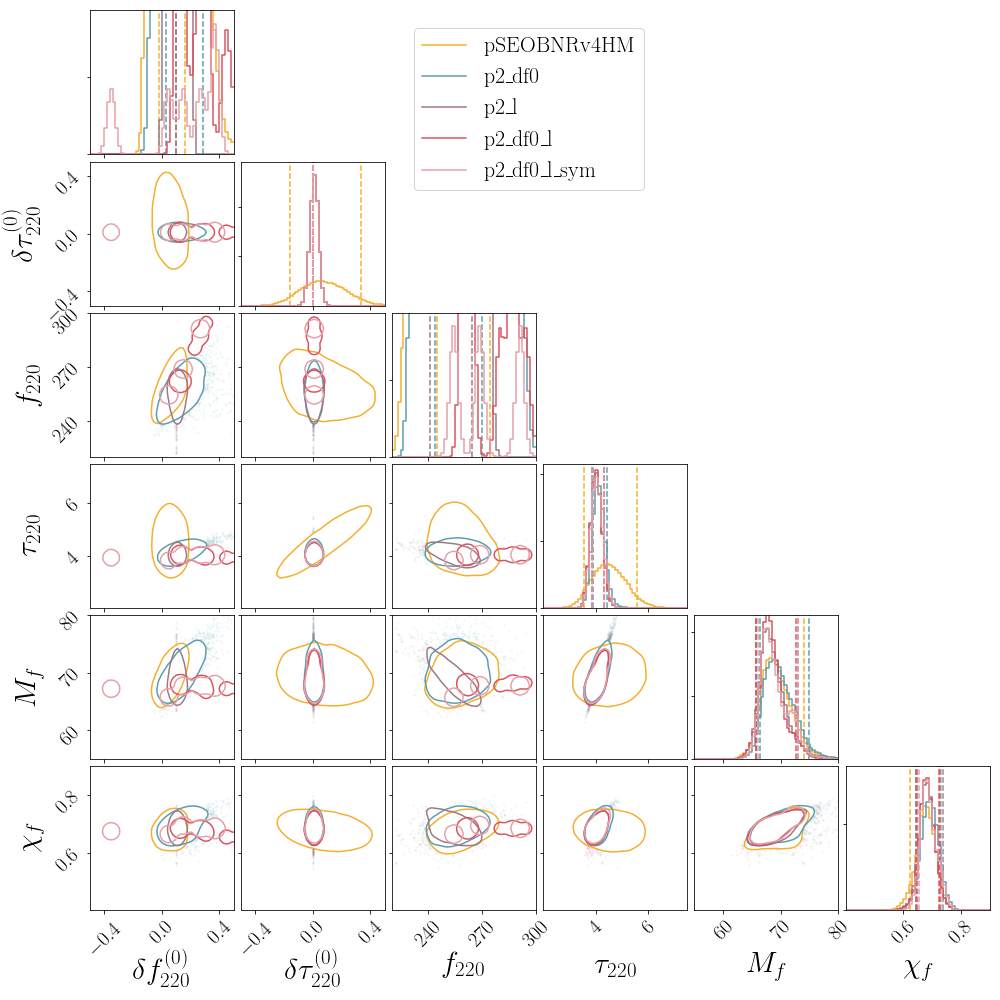

In [22]:
colors = ["#5c9ead","#9c7987","#db5461","#e6a1a8","#9b939f","#443850","#9d733f","#f6ae2d"]

plt.figure(figsize=(12,12))

nsamples = len(domega220_pseob)

fig = corner.corner(np.vstack([domega220_pseob, dtau220_pseob, f_pseob, tau_pseob, mf_pseob, af_pseob]).T, \
              bins=50, color=colors[-1], smooth=1.5, \
              smooth1d=1.5, weights=np.ones(nsamples)/nsamples, hist_bin_factor=1, 
              range=[[-0.5,0.5], [-0.5,0.5], [220,300],[2,7.5],[55,80],[0.4,0.9]],
              labels=['$\delta f_{220}^{(0)}$', '$\delta \\tau_{220}^{(0)}$', '$f _{220}$','$\\tau _{220}$', '$M_f$', '$\chi_f$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=None, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=None, plot_density=False, plot_contours=True, no_fill_contours=False, fill_contours=False )
plt.plot(0,0,color=colors[-1],label='pSEOBNRv4HM')

for idx, case in enumerate(parspec_cases):

    data_parspec = np.genfromtxt(parspec_root + 
                    "/" + case + "/cbcBayes/posterior_samples.dat", names=True, dtype=None)

    m1, m2, a1z, a2z, r = data_parspec["m1"], data_parspec["m2"], \
                            data_parspec["a1z"], data_parspec["a2z"], \
                            data_parspec["dist"]

    if "domega220" in data_parspec.dtype.names:
        domega220 = data_parspec["domega220"]
    else:
        domega220 = np.zeros(len(m1))
    if "dtau220" in data_parspec.dtype.names:
        dtau220 = data_parspec["dtau220"]
    else:
        dtau220 = np.zeros(len(m1))        
    if "domega210" in data_parspec.dtype.names:
        domega210 = data_parspec["domega210"]
    else:
        domega210 = np.zeros(len(m1))        
    if "dtau210" in data_parspec.dtype.names:
        dtau210 = data_parspec["dtau210"]
    else:
        dtau210 = np.zeros(len(m1))        
    if "alphaNGR" in data_parspec.dtype.names:
        alphaNGR = data_parspec["alphangr"]
    else:
        alphaNGR = np.ones(len(m1)) * alphaNGR_rep
        
    f_ps, tau_ps = eff_quant_parspec(m1, m2, a1z, a2z, r, domega220, dtau220, domega210, dtau210, alphaNGR, pNGR)
    tau_ps *= 1000.
    
    mf_ps, af_ps = data_parspec['mf_evol'], data_parspec['af_evol']
    
    nsamples = len(f_ps)
    
    corner.corner(np.vstack([domega220, dtau220, f_ps, tau_ps, mf_ps, af_ps]).T, bins=50, color=colors[idx], \
              smooth=1.5, smooth1d=1.5, weights=np.ones(nsamples)/nsamples, hist_bin_factor=1, 
              range=[[-0.5,0.5], [-0.5,0.5], [220,300],[2,7.5],[55,80],[0.4,0.9]],
              labels=['$\delta f_{220}^{(0)}$', '$\delta \\tau_{220}^{(0)}$', '$f _{220}$','$\\tau _{220}$', '$M_f$', '$\chi_f$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=fig, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=None, plot_contours=True, no_fill_contours=False, fill_contours=False )


    plt.plot(0,0,color=colors[idx],label=parspec_cases_labels[idx])

plt.legend(loc=[-3,5], fontsize=22)
#plt.tight_layout()
#plt.savefig("parspec.png")

In [ ]:
parspec_root = "../runs/O1O2/GW150914/parspec_runs"
parspec_cases = ["p0_df0" , "p0_df0_dtau0" ,  "p2_df0_alpha", "p4_df0_alpha","p6_df0_alpha"]
parspec_cases_labels = ["p0\_df0" , "p0\_df0\_dtau0" ,  "p2\_df0\_alpha", \
                        "p4\_df0\_alpha","p6\_df0\_alpha"]

f_pseob, tau_pseob = np.genfromtxt("../runs/O1O2/GW150914/220/cbcBayes/qnmtest/qnmtest_abs_params_f_tau_modGR_data.dat", unpack=True)

In [ ]:
colors = ["#5c9ead","#9c7987","#db5461","#e6a1a8","#9b939f","#443850","#9d733f","#f6ae2d"]

plt.figure(figsize=(12,12))

fig = corner.corner(np.vstack([domega220_pseob, dtau220_pseob,np.zeros(len(domega220_pseob)), np.zeros(len(domega220_pseob)), np.ones(len(domega220_pseob)), f_pseob, tau_pseob, mf_pseob, af_pseob]).T, bins=50, color=colors[-1], smooth=1.5, smooth1d=1.5, weights=None, hist_bin_factor=1, 
              range=[[-1.,1.], [-1,1],[-1.,1.], [-1,1], [0,2], [220,300],[2,7.5],[55,80],[0.4,0.9]],
              labels=['$\delta f_{220}^{(0)}$', '$\delta \\tau_{220}^{(1)}$','$\delta f_{220}^{(1)}$', '$\\alpha$', '$\delta \\tau_{220}^{(0)}$', '$f _{220}$','$\\tau _{220}$', '$M_f$', '$\chi_f$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=None, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=None, plot_density=None, plot_contours=None, no_fill_contours=False, fill_contours=False )
plt.plot(0,0,color=colors[-1],label='pSEOBNRv4HM')

for idx, case in enumerate(parspec_cases):
    data_parspec = np.genfromtxt(parspec_root + 
                    "/" + case + "/cbcBayes/posterior_samples.dat", names=True, dtype=None)

    m1, m2, a1z, a2z, r = data_parspec["m1"], data_parspec["m2"], \
                            data_parspec["a1z"], data_parspec["a2z"], \
                            data_parspec["dist"]

    if "domega220" in data_parspec.dtype.names:
        domega220 = data_parspec["domega220"]
    else:
        domega220 = np.zeros(len(m1))
    if "dtau220" in data_parspec.dtype.names:
        dtau220 = data_parspec["dtau220"]
    else:
        dtau220 = np.zeros(len(m1))        
    if "domega210" in data_parspec.dtype.names:
        domega210 = data_parspec["domega210"]
    else:
        domega210 = np.zeros(len(m1))        
    if "dtau210" in data_parspec.dtype.names:
        dtau210 = data_parspec["dtau210"]
    else:
        dtau210 = np.zeros(len(m1))        
    if "alphaNGR" in data_parspec.dtype.names:
        alphaNGR = data_parspec["alphangr"]
    else:
        alphaNGR = np.ones(len(m1))        
    
    f_ps, tau_ps = eff_quant_parspec_generalised(m1, m2, a1z, a2z, r, domega220, dtau220, domega210, dtau210, alphaNGR, pNGR)
    tau_ps *= 1000.
    
    mf_ps, af_ps = data_parspec['mf_evol'], data_parspec['af_evol']
    
    corner.corner(np.vstack([domega220, dtau220,domega210, dtau210, alphaNGR, f_ps, tau_ps, mf_ps, af_ps]).T, bins=50, color=colors[idx], smooth=1.5, smooth1d=1.5, weights=None, hist_bin_factor=1, 
              range=[[-1.,1.], [-1,1],[-1.,1.], [-1,1], [0,2], [220,300],[2,7.5],[55,80],[0.4,0.9]],
              labels=['$\delta f_{220}^{(0)}$', '$\delta \\tau_{220}^{(1)}$','$\delta f_{220}^{(1)}$', '$\\alpha$', '$\delta \\tau_{220}^{(0)}$', '$f _{220}$','$\\tau _{220}$', '$M_f$', '$\chi_f$'], 
              label_kwargs=None, titles=None, show_titles=False, title_kwargs=None, truths=None, 
              truth_color='#4682b4', scale_hist=False, quantiles=[0.05,0.95], levels=[0.9], verbose=False, fig=fig, max_n_ticks=3, 
              top_ticks=False, use_math_text=True, reverse=False, labelpad=0.0, hist_kwargs=None, 
              plot_datapoints=True, plot_density=True, plot_contours=True, no_fill_contours=False, fill_contours=False )


    plt.plot(0,0,color=colors[idx],label=parspec_cases_labels[idx])

plt.legend(loc=[-3,5], fontsize=22)
#plt.tight_layout()
plt.savefig("parspec.png")

In [ ]:
parspec_root = "../runs/O1O2/GW150914/parspec_runs"
parspec_cases = ["p2_df0_alpha", "p4_df0_alpha","p6_df0_alpha"]
parspec_cases_labels = ["D=2", "D=4","D=6"]

In [ ]:
colors = ["#5c9ead","#9c7987","#db5461","#e6a1a8","#9b939f","#443850","#9d733f","#f6ae2d"]

plt.figure()

for idx, case in enumerate(parspec_cases):
    data_parspec = np.genfromtxt(parspec_root + 
                    "/" + case + "/cbcBayes/posterior_samples.dat", names=True, dtype=None)

    alphaNGR = data_parspec["alphangr"]
    plt.hist(alphaNGR, bins=60, density=True, label=parspec_cases_labels[idx], alpha=0.5)


plt.legend(loc='best', fontsize=22)
plt.xlabel("$\ell$ (km)")
plt.ylabel("$P(\ell)$")
plt.xlim([0,150])
plt.show()
#plt.tight_layout()
#plt.savefig("parspec.png")